In [1]:
import itertools
import os
import re
import pickle
import platform
import time
import warnings

from functools import partial
from os.path import abspath, relpath, exists, join

import numpy as np
import pandas as pd
import seaborn as sns
import scipy.stats as stats
from matplotlib import pyplot as plt

from IPython import sys_info
from IPython.display import display, HTML, Image, Javascript, Markdown, SVG
from rsmtool.reader import DataReader
from rsmtool.writer import DataWriter
from rsmtool.utils import (float_format_func,
                           int_or_float_format_func,
                           compute_subgroup_plot_params,
                           parse_json_with_comments,
                           bold_highlighter,
                           color_highlighter,
                           show_thumbnail)

from rsmtool.version import VERSION as rsmtool_version

with warnings.catch_warnings():
    warnings.filterwarnings('ignore', category=FutureWarning)
    import statsmodels.api as sm

sns.set_context('notebook')

In [4]:
rsm_report_dir = '../../test_outputs/lr-subgroups-with-edge-cases/report/'
if rsm_report_dir is None:
    rsm_report_dir = os.getcwd()

rsm_environ_config = join(rsm_report_dir, '.environ.json')
if not exists(rsm_environ_config):
    raise FileNotFoundError('The file {} cannot be located. '
                            'Please make sure that either (1) '
                            'you have set the correct directory with the `RSM_REPORT_DIR` '
                            'environment variable, or (2) that your `.environ.json` '
                            'file is in the same directory as your notebook.'.format(rsm_environ_config))
    
environ_config = parse_json_with_comments(rsm_environ_config)

In [5]:
# NOTE: you will need to set the following manually
# if you are using this notebook interactively.
experiment_id = environ_config.get('EXPERIMENT_ID')
description = environ_config.get('DESCRIPTION')
context = environ_config.get('CONTEXT')
train_file_location = environ_config.get('TRAIN_FILE_LOCATION')
test_file_location = environ_config.get('TEST_FILE_LOCATION')
output_dir = environ_config.get('OUTPUT_DIR')
figure_dir = environ_config.get('FIGURE_DIR')
model_name = environ_config.get('MODEL_NAME')
model_type = environ_config.get('MODEL_TYPE')
skll_objective = environ_config.get('SKLL_OBJECTIVE')
file_format = environ_config.get('FILE_FORMAT')
length_column = environ_config.get('LENGTH_COLUMN')
second_human_score_column = environ_config.get('H2_COLUMN')
use_scaled_predictions = environ_config.get('SCALED')
min_score = environ_config.get("MIN_SCORE")
max_score = environ_config.get("MAX_SCORE")
standardize_features = environ_config.get('STANDARDIZE_FEATURES')
exclude_zero_scores = environ_config.get('EXCLUDE_ZEROS')
feature_subset_file = environ_config.get('FEATURE_SUBSET_FILE', ' ')
min_items = environ_config.get('MIN_ITEMS')
use_thumbnails = environ_config.get('USE_THUMBNAILS')
predict_expected_scores = environ_config.get('PREDICT_EXPECTED_SCORES')

# groups for analysis by prompt or subgroup.
groups_desc = environ_config.get('GROUPS_FOR_DESCRIPTIVES') 
groups_eval = environ_config.get('GROUPS_FOR_EVALUATIONS') 

# javascript path
javascript_path = environ_config.get("JAVASCRIPT_PATH")

In [9]:
# Read in the training and testing features, both raw and pre-processed
# Make sure that the `spkitemid` and `candidate` columns are read as strings 
# to preserve any leading zeros
# We filter DtypeWarnings that pop up mostly in very large files

string_columns = ['spkitemid', 'candidate']
converter_dict = {column: str for column in string_columns}

with warnings.catch_warnings():
    warnings.filterwarnings('ignore', category=pd.io.common.DtypeWarning)
    if exists(train_file_location):
        df_train_orig = DataReader.read_from_file(train_file_location)

    train_file = join(output_dir, '{}_train_features.{}'.format(experiment_id,
                                                                file_format))
    if exists(train_file):
        df_train = DataReader.read_from_file(train_file, converters=converter_dict)

    train_metadata_file = join(output_dir, '{}_train_metadata.{}'.format(experiment_id,
                                                                         file_format))    
    if exists(train_metadata_file):
        df_train_metadata = DataReader.read_from_file(train_metadata_file, converters=converter_dict)

    train_other_columns_file = join(output_dir, '{}_train_other_columns.{}'.format(experiment_id,
                                                                                   file_format))
    if exists(train_other_columns_file):
        df_train_other_columns = DataReader.read_from_file(train_other_columns_file, converters=converter_dict)

    train_length_file = join(output_dir, '{}_train_response_lengths.{}'.format(experiment_id,
                                                                               file_format))
    if exists(train_length_file):
        df_train_length = DataReader.read_from_file(train_length_file, converters=converter_dict)

    train_excluded_file = join(output_dir, '{}_train_excluded_responses.{}'.format(experiment_id,
                                                                                   file_format))
    if exists(train_excluded_file):
        df_train_excluded = DataReader.read_from_file(train_excluded_file, converters=converter_dict)

    train_responses_with_excluded_flags_file = join(output_dir, '{}_train_responses_with_excluded_flags.{}'.format(experiment_id,
                                                                                                                   file_format))
    if exists(train_responses_with_excluded_flags_file):
        df_train_responses_with_excluded_flags = DataReader.read_from_file(train_responses_with_excluded_flags_file,
                                                                           converters=converter_dict)

    train_preproc_file = join(output_dir, '{}_train_preprocessed_features.{}'.format(experiment_id,
                                                                                     file_format))    
    if exists(train_preproc_file):
        df_train_preproc = DataReader.read_from_file(train_preproc_file, converters=converter_dict)

    if exists(test_file_location):
        df_test_orig = DataReader.read_from_file(test_file_location)

    test_file = join(output_dir, '{}_test_features.{}'.format(experiment_id,
                                                              file_format))
    if exists(test_file):
        df_test = DataReader.read_from_file(test_file, converters=converter_dict)

    test_metadata_file = join(output_dir, '{}_test_metadata.{}'.format(experiment_id,
                                                                       file_format))    
    if exists(test_metadata_file):
        df_test_metadata = DataReader.read_from_file(test_metadata_file, converters=converter_dict)

    test_other_columns_file = join(output_dir, '{}_test_other_columns.{}'.format(experiment_id,
                                                                                 file_format))
    if exists(test_other_columns_file):
        df_test_other_columns = DataReader.read_from_file(test_other_columns_file, converters=converter_dict)

    test_human_scores_file = join(output_dir, '{}_test_human_scores.{}'.format(experiment_id,
                                                                               file_format))
    if exists(test_human_scores_file):
        df_test_human_scores = DataReader.read_from_file(test_human_scores_file, converters=converter_dict)

    test_excluded_file = join(output_dir, '{}_test_excluded_responses.{}'.format(experiment_id,
                                                                                 file_format))
    if exists(test_excluded_file):
        df_test_excluded = DataReader.read_from_file(test_excluded_file, converters=converter_dict)

    test_responses_with_excluded_flags_file = join(output_dir, '{}_test_responses_with_excluded_flags.{}'.format(experiment_id,
                                                                                                                 file_format))
    if exists(test_responses_with_excluded_flags_file):
        df_test_responses_with_excluded_flags = DataReader.read_from_file(test_responses_with_excluded_flags_file,
                                                                          converters=converter_dict)

    test_preproc_file = join(output_dir, '{}_test_preprocessed_features.{}'.format(experiment_id,
                                                                                   file_format))
    if exists(test_preproc_file):
        df_test_preproc = DataReader.read_from_file(test_preproc_file, converters=converter_dict)

    pred_preproc_file = join(output_dir, '{}_pred_processed.{}'.format(experiment_id,
                                                                       file_format))
    if exists(pred_preproc_file):
        df_pred_preproc = DataReader.read_from_file(pred_preproc_file, converters=converter_dict)

    feature_file = join(output_dir, '{}_feature.{}'.format(experiment_id,
                                                           file_format))
    if exists(feature_file):
        df_features = DataReader.read_from_file(feature_file, converters=converter_dict)
        features_used = [c for c in df_features.feature.values]

    betas_file = join(output_dir, '{}_betas.{}'.format(experiment_id,
                                                       file_format))
    if exists(betas_file):
        df_betas = DataReader.read_from_file(betas_file)

    if exists(feature_subset_file):
        df_feature_subset_specs = DataReader.read_from_file(feature_subset_file)
    else:
        df_feature_subset_specs = None

## Additional fairness analyses

This section presents additional fairness analyses described in detail in [Loukina et al. (2019)](www.aclweb.org).
These analyses consider separately different definitions of fairness and can assist in further trouble-shooting 
the observed subgroup differences. The evaluations focuses on three dimensions:

* Overall score accuracy: whether automated scores are equally accurate for each group. The metric shows how much of variance in squared error $(S-H)^2$ is explained by subgroup membership. 

* Overall score difference: whether automated scores are consistently different from human scores for members of a certain group. The metric shows how much of variance in actual error $S-H$ is explained by subgroup membership. 

* Conditional score difference: whether automated scoring engines assign different scores to speakers from different groups despite their having the same language proficiency. The metric shows how much additional variance in actual error ($S-H$) is explained by subgroup membership after controlling for human proficiency score. 

In [25]:
df_pred_preproc_merged['group_edge_cases'].value_counts().index

Index(['NormalGroup', 'SameHumanScore', 'ThreeResponses', 'TwoResponses',
       'SingleResponse'],
      dtype='object')

In [73]:
import statsmodels.formula.api as smf
from statsmodels.stats.anova import anova_lm

def get_significant(res, system_score='raw_trim'):
        out_dict = {}
        sigs = list(res.pvalues[res.pvalues<0.01].index)
        
        sig_langs = [v for v in sigs if 'group' in v]
        
        for v in sig_langs:
            if v == 'Intercept':
                key = v
            else:
                key = v.split('.')[1].strip(']')
            out_dict[key] = res.params[v]
        return out_dict


def convert_to_category(group_values):
    groups_by_size = group_values.value_counts().index
    group_category = group_values.astype("category")
    group_ordered_category = group_category.cat.reorder_categories(groups_by_size,
                                                               ordered=True)
    return group_ordered_category
    
    
    
def get_fairness_analysis(df, group,
                          system_score_column='raw_trim',
                          human_score_column='sc1'):
    ''' Main function for computing various fairness metrics'''
    
    # compute error and squared error

    df['error'] = df['raw_trim']-df['sc1']
    df['SE'] = df['error']**2

    # convert group values to category and reorder them using 
    # the largest category as reference
    
    df['group'] = convert_to_category(df[group])
    base_group = df['group'].cat.categories[0]
    df['sc1_cat'] = convert_to_category(df['sc1'])

    
    # now do the same for the human score

    
    # Overall score accuracy (OSA)
    # Variance in squared error explained by L1
    
    mod1 = smf.ols(formula='SE ~ group', data=df)
    res1 = mod1.fit()


    df_1 = {'R2': res1.rsquared_adj}
    df_1.update(get_significant(res1))
    df_1['sig'] = np.round(res1.f_pvalue, 5)
    df_1 = pd.Series(df_1, name='Overall score accuracy')


    # Overall score difference (OSD)
    # variance in signed residuals (raw error) explained by L1

    mod2 = smf.ols(formula='error ~ group', data=df)
    res2 = mod2.fit()


    df_2 = {'R2': res2.rsquared_adj}
    df_2.update(get_significant(res2))
    df_2['sig'] = np.round(res2.f_pvalue, 5)
    df_2 = pd.Series(df_2, name='Overall score error')

    # conditional score difference CSD 
    # Variance in score difference conditioned on Native language
    
    mod0 = smf.ols(formula='error ~ sc1_cat', data=df)
    res0 = mod0.fit()
    mod3 = smf.ols(formula='error ~ group + sc1_cat', data=df)
    res3 = mod3.fit()


    df_3 = {'R2': res3.rsquared_adj - res0.rsquared_adj}
    df_3.update(get_significant(res3))
    df_3['sig'] = np.round(anova_lm(res0, res3).values[1][-1], 5)
    df_3 = pd.Series(df_3, name='Conditional score error')


    df_all = pd.concat([df_1, df_2, df_3], axis=1, sort=True)
    df_all['base_category'] = base_group
    return df_all

### group_edge_cases

The summary table shows the overall score accuracy (OSA), overall score difference (OSD) and conditional score difference (CSD). The first row reports the percentage of variance, the second raw shows $p$ value. Further detail about each model can be found in intermediate output files

/Users/aloukina/miniconda3/envs/rsmtool/lib/python3.6/site-packages/scipy/stats/_distn_infrastructure.py:879: RuntimeWarning: invalid value encountered in greater
  return (self.a < x) & (x < self.b)
/Users/aloukina/miniconda3/envs/rsmtool/lib/python3.6/site-packages/scipy/stats/_distn_infrastructure.py:879: RuntimeWarning: invalid value encountered in less
  return (self.a < x) & (x < self.b)
/Users/aloukina/miniconda3/envs/rsmtool/lib/python3.6/site-packages/scipy/stats/_distn_infrastructure.py:1821: RuntimeWarning: invalid value encountered in less_equal
  cond2 = cond0 & (x <= self.a)


,Overall score accuracy,Overall score error,Conditional score error,base_category
R2,0.522971,0.545701,0.073574,NormalGroup
SameHumanScore,1.951007,1.493293,0.891120,NormalGroup
sig,0.000000,0.000000,0.000000,NormalGroup


The plot shows average system score (raw) for each group conditioned on the human score

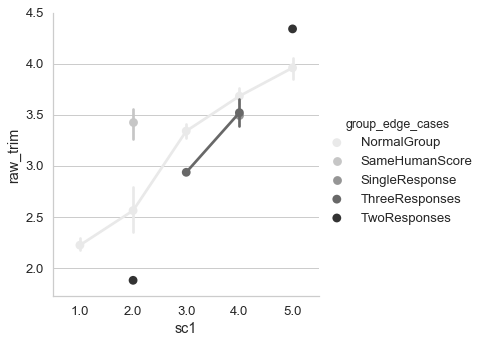

In [74]:
# check if we already created the merged file in another notebook

try:
    df_pred_preproc_merged
except NameError:
    df_pred_preproc_merged = pd.merge(df_pred_preproc, df_test_metadata, on = 'spkitemid')

for group in groups_eval:
    display(Markdown("### {}".format(group)))
    display(Markdown("The summary table shows the overall score accuracy (OSA), overall score difference (OSD) "
                    "and conditional score difference (CSD). The first row reports the percentage of variance, "
                    "the second raw shows $p$ value. Further detail about each model can be found in intermediate "
                    "output files"))
    
    
    df_fairness = get_fairness_analysis(df_pred_preproc_merged, 'group_edge_cases')
    display(HTML(df_fairness.to_html(classes='sortable')))
    # show the plot
    group_values = sorted(df_pred_preproc_merged[group].unique())
    display(Markdown("The plot shows average system score ({}) for each group "
                     "conditioned on the human score".format('raw')))
    colors = sns.color_palette("Greys", len(group_values))
    with sns.axes_style('whitegrid'), sns.plotting_context('notebook', font_scale=1.2):
        p = sns.catplot(x='sc1', y='raw_trim',
                        hue=group, hue_order = group_values,
                        palette=colors,
                        legend_out=True,
                        kind="point",
                        data=df_pred_preproc_merged)

        #plt.tight_layout(h_pad=1.0)
        imgfile = join(figure_dir, '{}_conditional_score_{}.svg'.format(experiment_id, group))
        plt.savefig(imgfile)
        if use_thumbnails:
            show_thumbnail(imgfile, next(id_generator))
        else:
            plt.show()